# Explaining Tree Models with Tree SHAP

## Introduction

This example shows how to apply Tree SHAP to compute shap values exactly for an `xgboost` model fitted to the `Adult` dataset (binary classification task). Following an exploration of the different parameters that can be ajusted to optimise `xgboost` perfromance, the path-dependent and interventional feature perturbation variants of Tree SHAP are employed to explain the model and the results discussed. Furthermore, it is shown how the contribution  of any given feature can be further decomposed into a main effect and interactions with other features. Finally,  Kernel SHAP, an algorithm that approximates the shap values, is shown to approach the exact value given a sufficiently large number of model evaluations.

In [371]:
import pickle
import shap
shap.initjs()

import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from alibi.datasets import fetch_adult
from alibi.explainers import KernelShap
from collections import defaultdict
from copy import deepcopy
from functools import partial
from itertools import chain, product, zip_longest

from scipy.special import expit
invlogit=expit
from shap import TreeExplainer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import resample
from tqdm import tqdm

from timeit import default_timer as timer

## Data preparation

### Load and split

The `fetch_adult` function returns a `Bunch` object containing the features, the targets, the feature names and a mapping of categorical variables to numbers.

In [2]:
adult = fetch_adult()
adult.keys()

dict_keys(['data', 'target', 'feature_names', 'target_names', 'category_map'])

In [3]:
data = adult.data
target = adult.target
target_names = adult.target_names
feature_names = adult.feature_names
category_map = adult.category_map

Note that for your own datasets you can use the utility function `gen_category_map` imported from `alibi.utils.data`  to create the category map.

In [4]:
np.random.seed(0)
data_perm = np.random.permutation(np.c_[data, target])
data = data_perm[:,:-1]
target = data_perm[:,-1]

In [5]:
idx = 30000
X_train,y_train = data[:idx,:], target[:idx]
X_test, y_test = data[idx+1:,:], target[idx+1:]

### Create feature transformation pipeline and preprocess data

The feature pre-processor needs to have `fit` and `transform` methods and different types of pre-processing can be applied to all or part of the features. Since trees are invariant to input scaling, the pipeline does not contain a feature standardisation step.

Unlike in a previous [example](kernel_shap_adult_lr.ipynb), the categorical variables are not encoded. For linear models such as logistic regression, using an encoding of the variable that assigns a unique integer to a category will affect the coefficient estimates as the model will learn patterns based on the ordering of the input, which is incorrect. In contrast, by encoding the into a sequence of binary variables, the model can learn which encoded dimensions are relevant for predicting a given target but cannot represent non-linear relations between the categories and targets. 

On the other hand, decision trees can naturally handle both data types simultaneously; a categorical feature can be used for splitting a node multiple times. So, hypothetically speaking, if the categorical variable `var` has `4` levels, encoded `0-3` and level `2` correlates well with a particular outcome, then a decision path could contain the splits `var < 3` and `var > 1` if this pattern generalises in the data and thus splitting according to these criteria reduce the splits' impurity. 

In general, we note that for a categorical variable with $q$ levels there are $2^{q-1}-1$ possible partitions into two groups, and for large $q$ finding an optimal split is intractable. However, for binary classification problems an optimal split can be found efficiently (see references in [[1]](#References)). As $q$ increases, the number of potential splits to choose from increases, so it is more likely that a split that fits the data is found. For large $q$ this can lead to overfitting, so variables with large number of categories can potentially harm model performance.

The interested reader is referred to consult these blog posts ([first](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/), [second](https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769)), which demonstrate of the pitfalls of encoding categorical data as one-hot when using tree-based models. `sklearn` expects that the categorical data is encoded, and this approach should be followed when working with this library.

<a id='source_4'></a>

In [6]:
ordinal_features = [x for x in range(len(feature_names)) if x not in list(category_map.keys())]
ordinal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

Categorical features:

In [7]:
categorical_features = list(category_map.keys())
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

Combine and fit:

In [8]:
preprocessor = ColumnTransformer(transformers=[('num', ordinal_transformer, ordinal_features),
                                               ('cat', categorical_transformer, categorical_features)])
preprocessor.fit(X_train)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('imputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='median',
                                                                verbose=0))],
                                          verbose=False),
                                 [0, 8, 9, 10]),
                                ('cat',
                                 Pipeline(memory=None,
                                         

Preprocess: 

In [9]:
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

In [10]:
print("Number of training examples in {} class: {}".format(target_names[0], len(y_train) - y_train.sum()))
print("Number of training examples in {} class: {}".format(target_names[1], y_train.sum()))
print("\nNumber of testing examples in {} class: {}".format(target_names[0], len(y_test) - y_test.sum()))
print("Number of testing examples in {} class: {}".format(target_names[1], y_test.sum()))
      

Number of training examples in <=50K class: 22771
Number of training examples in >50K class: 7229

Number of testing examples in <=50K class: 1948
Number of testing examples in >50K class: 612


The preprocessor alters the column order of `X_train` and `X_test`:

In [11]:
numerical_feats_idx  = preprocessor.transformers_[0][2]
categorical_feats_idx  = preprocessor.transformers_[1][2]
num_feats_names = [feature_names[i] for i in numerical_feats_idx]
cat_feats_names = [feature_names[i] for i in categorical_feats_idx]
feat_names = num_feats_names + cat_feats_names
print("Feature order:")
print(feat_names)

Feature order:
['Age', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Workclass', 'Education', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']


Finally, a matrix that contains the raw string values for categorical variables (used for display) is created:

In [12]:
def _decode_data(X, X_feature_names, feature_names, category_map):
    """
    Given an encoded data matrix `X` returns a matrix where the 
    categorical levels have been replaced by human readable categories.
    `feature_names` is necessary as the indices of `category_map` are
    into this list (sklearn permutes the columns on preprocessing)
    """
    
    X_new = np.zeros(X.shape, dtype=object)
    for i, name in enumerate(X_feature_names):
        idx = feature_names.index(name)
        categories = category_map.get(idx, None)
        if categories:
            for j, category in enumerate(categories):
                encoded_vals = X[:, i] == j
                X_new[encoded_vals, i] = category
        else:
            X_new[:, i] = X[:, i]
        
    return X_new
            
decode_data = partial(_decode_data,
                     feature_names=feature_names,
                     category_map=category_map)

In [13]:
X_display = decode_data(X_test_proc, feat_names)

## Model optimisation
<a id='optimisation'></a>


Users familiar with `xgboost` are encouraged to proceed to the [Model training section](#training), where the results of this section are summarised in the `params` dictionary.

`xgboost` wraps arrays using  `DMatrix` objects, optimised for both memory efficiency and training speed.

In [14]:
def wrap(arr):
    return np.ascontiguousarray(arr)

In [15]:
dtrain = xgb.DMatrix(
    wrap(X_train_proc), 
    label=wrap(y_train), 
    feature_names=feat_names, 
)

In [16]:
dtest = xgb.DMatrix(wrap(X_test_proc), label=wrap(y_test), feature_names=feat_names)


`xgboost` defines three classes of parameters that need to be configured in order to train and/or optimise a model:
* general parameters: high level settings such as the type of boosting model
* learning parameters: these are parameters that control the boosting process (model hyperparameters)
* learning task parameters: define the optimisation objective and the metric on which the validation performance is measured

In [17]:
learning_params = {}
booster_params = {}
general_params = {}
params = {}

This is a binary classification problem, optimised with binary cross-entropy as an objective, defined as:
<a id='f_1'></a>

$$
J (y_i, \hat{y}_i) = -\frac{1}{N} \sum_{i=1}^N [y_i \log(1 + e^{- \hat{y}_i}) + (1 - y_i) \log (1 + e^{\hat{y}_i})]
$$

where $y_i$ is the true label for the $i$th observation and $\hat{y}_i$ is the decision score (logit) <sup>[(1)](#Footnotes) </sup> of the positive class (whose members' income exceeds \$50,000). Setting the objective to `binary:logitraw` means the call to the `predict` method will output $\hat{y}_i$. 

<a id='f_1'></a>


In [18]:
learning_params.update({
    'objective':'binary:logitraw',
    'seed': 42,
    'eval_metric': ['auc', 'logloss'] # metrics computed for specified dataset
})

The [AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) will be used as a target for early stopping during hyperparameter optimisiation . Using this metric as opposed to, e.g., accuracy helps deal with the imbalanced data since this metric balances the true positive rate and the false positive rate. However, it should be noted that AUC is an _aggregate_ performace measure since it is derived by matching predicted labels with ground truths across models with different output thresholds. In practice, however, only one such model is selected. Thus, a higher AUC just reflects that on average, the ensamble performs better. However, whether the classifier selected according to this metric is optimal depends on the threshold chosen for converting the predicted probabilities to class labels.

Additionally, the weights of the positive are scaled to reflect the class imbalance. A common setting is to scale the positive class by the ratio of the negative to positive examples (approximately 3 for this dataset). Since this is a heuristic approach, this parameter will be cross-validated.


The first parameters optimised are:
* `max_depth`: the maximum depth of any tree added to the ensamble. Deeper trees are more accurate (on training data) since they represent more specific rules
* `min_child_weight`: child nodes are required to have a total weight above this threshold for a split to occur. For a node $L$, this weight is computed according to 
$$
H_L = \sum_{i}w_i  \frac{\partial^2 J (y_i, \hat{y}_{i,{t-1}})}{\partial {\hat{y}_{i,t-1}}^2}
$$
where the summation of hessians is over all examples $i$ split at the node, and the subscript $t-1$ indicates that the derivative is with respect to the output evaluated at the previous round in the boosting [process](https://xgboost.readthedocs.io/en/latest/tutorials/model.html). In this example, the weight $w_i$ depends on the class and is controlled through the `scale_pos_weight` argument. The second derivative above is given by

$$
\frac{2 e^{\hat{y}_i}}{{(1 + e^{\hat{y}_i})}^2},
$$
whose variation is depicted in Figure 1.

![hessian](hess.png)
Figure 1: Hessian of the loss function

Figure 1 shows that when the classifier assigns a high positive or a low negative score, the contribution of data point $i$ to the child weight is very small. Therefore, setting a very small value for `min_child_weight` parameter can result in overfitting since the splitting process will make splits in order to ensure the instances in a leaf are correctly classified at the expense of finding more parsimonious rules that generalise well.
* `scale_pos_weight`: a scaling factor applied to the positive class to deal with class imbalance
* `gamma`: is a parameter that controls the minimum gain that has to be attained in order for a split to be made

To understand `gamma`, recall that the _gain_ of making a particular split is defined as function of the _structure scores_ of the left (L) and right (R) child nodes and the structure score of the parent as 

$$
gain = \frac{1}{2}\left[\frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{{(G_L+G_R)}^2}{H_L + H_R + \lambda}  \right] - \gamma
$$

where $\lambda$ is a regularisation hyperparameter shrinking the model output, $H_L$ is defined above and $G_L$ is given by

$$
G_L = \sum_{i}w_i  \frac{\partial J (y_i, \hat{y}_{i,{t-1}})}{\partial {\hat{y}_{i,t-1}}}
$$

and $i$ sums over the points that flow throught the node $L$. Note that these structure scores represent minimisers of the objective (which is simply a quadratic in the leaf value). To make a split, the gain should exceed $\gamma$.


The _learning rate_ (`eta`) is fixed. This parameter is the fraction of the output score a member of the ensamble contributes to the decision score. Lower values yield larger ensambles.

In [19]:
def tune_params(dtrain, base_params,  param_dict, maximise=True, prev_optimum=None, **kwargs):
    """
        Given a training set `dtrain`, a dictionary of parameters to be optimised `param_dict` and 
        all the other learning and booster parameters (`base_param`), this function runs an 
        exhaustive grid search over the tuning parameters.
        
        NB: Specifying `prev_optimum` allows one to tune parameters in stages. maximise should indicate
        if the evaluation metric should be maximised during CV.
    """

    def _statistic(maximise, argument=False):
        if maximise:
            if argument:
                return np.argmax
            return np.max
        if argument:
            return np.argmin
        return np.min
    
    
    def _compare(optimum, val, maximise=True):
        
        eps=1e-4
        
        if maximise:
            if val > optimum + eps:
                return True
            return False
        if val < optimum - eps:
            return True
        return False
    
    statistic = partial(_statistic, maximise)
    compare = partial(_compare, maximise=maximise)
    metrics = kwargs.get("metrics")
    if isinstance(metrics, list):
        opt_metric = metrics[-1]
    else:
        opt_metric = metrics

    print(f"CV with params: {list(param_dict.keys())}")
    print(f"Tracked metrics: {metrics}")
    print(f"Cross-validating on: {opt_metric}")
    
    if prev_optimum:
        optimum = prev_optimum
    else:    
        optimum = -float("Inf") if maximise else float("Inf")
    
    params = deepcopy(base_params)
    pars, pars_val = list(param_dict.keys()), list(param_dict.values())
    combinations = list(product(*pars_val))
    best_combination = {}
    
    # run grid search
    for combination in tqdm(combinations):
        for p_name, p_val in zip(pars, combination):
            params[p_name] = p_val
        cv_results = xgb.cv(
            params,
            dtrain,
            **kwargs,
        )
        mean = statistic()(cv_results[f'test-{opt_metric}-mean'])
        boost_rounds = statistic(argument=True)(cv_results[f'test-{opt_metric}-mean'])    
        improved = compare(optimum, mean)
        if improved:
            optimum = mean
            for name, val in zip(pars, combination):
                best_combination[name]=val
            print(f"{opt_metric} mean value: {mean} at {boost_rounds} rounds")
            msg = 'Best params:' + '\n{}: {}'*len(pars)
            print(msg.format(*list(chain(*best_combination.items()))))
        
    return optimum, best_combination, boost_rounds


In [20]:
booster_params.update({'eta': 0.1})

In [21]:
tuning_params={
        'scale_pos_weight': [2, 3, 4, 5],
        'min_child_weight': [0.1, 0.5, 1.0, 2.0, 5.0],
        'max_depth': [3, 4, 5, 6],
        'gamma': [0.01, 0.05, 0.08, 0.1, 0.2]
}

All parameters apart from the ones tuned are included in `params`. The cross validation process is controlled through `cv_opts`.

In [ ]:
params.update(general_params)
params.update(learning_params)
params.update(booster_params)

In [22]:
cv_opts = {
    'num_boost_round': 1000,
    'nfold': 5, 
    'stratified': True,
    'metrics': ['logloss', 'aucpr', 'auc'],  # can alternatively perform early stopping on log-loss or aucpr
    'early_stopping_rounds': 20,
    'seed': 42,
}

Optimise `scale_pos_weight`, `min_child_weight`, `max_depth` and `gamma`. 

In [23]:
optimum, best_params, boost_rounds = tune_params(dtrain, 
                                                 params, 
                                                 tuning_params, 
                                                 maximise=True, 
                                                 **cv_opts
                                                )

  0%|          | 0/400 [00:00<?, ?it/s]

CV with params: ['scale_pos_weight', 'min_child_weight', 'max_depth', 'gamma']
Tracked metrics: ['logloss', 'aucpr', 'auc']
Cross-validating on: auc


  0%|          | 1/400 [00:08<57:51,  8.70s/it]

auc mean value: 0.9284952000000001 at 541 rounds
Best params:
scale_pos_weight: 2
min_child_weight: 0.1
max_depth: 3
gamma: 0.01


100%|██████████| 400/400 [34:06<00:00,  5.12s/it]

boost rounds 116


In [24]:
if best_params:
    params.update(best_params)
    params.update({'boost_rounds': boost_rounds})

In [25]:
params

{'objective': 'binary:logitraw',
 'seed': 42,
 'eval_metric': ['auc', 'logloss'],
 'eta': 0.1,
 'scale_pos_weight': 2,
 'min_child_weight': 0.1,
 'max_depth': 3,
 'gamma': 0.01,
 'boost_rounds': 116}


Further optimisation is possible by adjusting the following parameters:
* `subsample`: this is the ratio of the total training examples that will be used for training during each boosting round
* `colsamplebytree`: this is the ratio of the features used to fit an ensamble member during a boosting round

Training on uniformly chosen data subsamples with uniformly chosen subsets of features promotes noise robustness. 

In [26]:
tuning_params = {
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsamplebytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

In [27]:
optimum, best_params, boost_rounds = tune_params(dtrain, 
                                                 params, 
                                                 tuning_params, 
                                                 maximise=True, 
                                                 prev_optimum=optimum,
                                                 **cv_opts
                                                )

  0%|          | 0/25 [00:00<?, ?it/s]

CV with params: ['subsample', 'colsamplebytree']
Tracked metrics: ['logloss', 'aucpr', 'auc']
Cross-validating on: auc


100%|██████████| 25/25 [02:57<00:00,  7.09s/it]

boost rounds 541



None of the stated configuration resulted in an improvement of the AUC, which could be a consequence of the fact that:
* the parameters selected in the previous round provide strong model regularisation; in particular, the maximum tree depth for any ensamble member is 3, which means only a subset of features are used anyway to perform the splits in any given tree. Further subsampling may thus not be effective since the subsampling is already implicit in the chosen tree structure
* the AUC is insensitive to small model changes since it measures how the proportion of false positives changes as the number of false negatives changes across a range of models. The confidence of the models does not feature in this measure (since a highly confident classifier and one that predicts probabilities near the decision threshold will have identical AUC)

In [28]:
if best_params:
    params.update(best_params)
    params.update({'boost_rounds': boost_rounds})

In [29]:
params

{'objective': 'binary:logitraw',
 'seed': 42,
 'eval_metric': ['auc', 'logloss'],
 'eta': 0.1,
 'scale_pos_weight': 2,
 'min_child_weight': 0.1,
 'max_depth': 3,
 'gamma': 0.01,
 'boost_rounds': 116}

To prevent overfitting, a regulariser $\Omega(f_t)$ with the form 

$$
\Omega(f_t) = \gamma T + \frac{\lambda}{2} \sum_{j=1}^T s_{j,t}^2
$$

is added to the objective function at every boosting round $t$. Above $T$ is the total number of leaves and $s_{j,t}$ is the score of the $j$th leaf at round $t$. For the binary logistic objective, a higher $\lambda$ penalises confident predictions (shirnks the scores). 

By default $\lambda = 1$. Since subsampling data and features did not improve the performance, we explore with relaxing regularisation in order to adjust the model regularisation.

In [30]:
tuning_params = {
    'lambda': [0.01, 0.1, 0.5, 0.9, 0.95, 1, 2, 5, 10]
}

In [31]:
optimum, best_params, boost_rounds = tune_params(dtrain, 
                                                 params, 
                                                 tuning_params, 
                                                 maximise=True, 
                                                 prev_optimum=optimum,
                                                 **cv_opts)

  0%|          | 0/9 [00:00<?, ?it/s]

CV with params: ['lambda']
Tracked metrics: ['logloss', 'aucpr', 'auc']
Cross-validating on: auc


100%|██████████| 9/9 [01:23<00:00,  9.28s/it]


In [32]:
if best_params:
    params.update(best_params)
    params.update({'boost_rounds': boost_rounds})

## Model training
<a id='training'></a>

The model will now be trained with the following parameters (skip the `param` update if you ran the optimisation section):

In [33]:
learning_params = {
    'objective':'binary:logitraw',
    'seed': 42,
    'eval_metric': ['auc', 'logloss'] # metrics computed for specified dataset
}


params = { 
    'scale_pos_weight': 2,
    'min_child_weight': 0.1,
    'max_depth': 3,
    'gamma': 0.01, 
    'boost_rounds': 541,
}

params.update(learning_params)

In [ ]:
if 'boost_rounds' in params:
    boost_rounds = params.pop('boost_rounds')

model = xgb.train(
    params,
    dtrain,
    num_boost_round=boost_rounds,
    evals=[(dtrain, "Train"), (dtest, "Test")],
)

## Model assessemnt

The confusion matrix is used to quanity the model performance below.

In [35]:
def plot_conf_matrix(y_test, y_pred, class_names):
    """
    Plots confusion matrix. Taken from:
    http://queirozf.com/entries/visualizing-machine-learning-models-examples-with-scikit-learn-and-matplotlib
    """
    
    matrix = confusion_matrix(y_test,y_pred)


    # place labels at the top
    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top')

    # plot the matrix per se
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)

    # plot colorbar to the right
    plt.colorbar()

    fmt = 'd'

    # write the number of predictions in each bucket
    thresh = matrix.max() / 2.
    for i, j in product(range(matrix.shape[0]), range(matrix.shape[1])):

        # if background is dark, use a white number, and vice-versa
        plt.text(j, i, format(matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if matrix[i, j] > thresh else "black")

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('True label',size=14)
    plt.xlabel('Predicted label',size=14)
    plt.show()


In [36]:
def predict(xgb_model, dataset, proba=False, threshold=0.5):
    """
    Predicts labels given a xgboost model that outputs raw logits. 
    """
    
    y_pred = model.predict(dataset)  # raw logits are predicted
    y_pred_proba = invlogit(y_pred) 
    if proba:
        return y_pred_proba
    y_pred_class = np.zeros_like(y_pred)
    y_pred_class[y_pred_proba >= threshold] = 1  # assign a label 
    
    return y_pred_class
    

In [37]:
y_pred_train = predict(model, dtrain)
y_pred_test = predict(model, dtest)

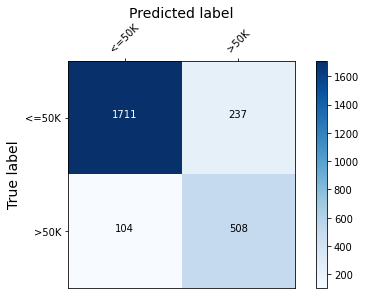

In [38]:
plot_conf_matrix(y_test, y_pred_test, target_names)

In [148]:
print(f'Train accuracy:  {round(100*accuracy_score(y_train, y_pred_train), 4)}  %.')
print(f'Test  accuracy:  {round(100*accuracy_score(y_test, y_pred_test), 4)}%.')

Train accuracy:  87.75  %.
Test  accuracy:  86.6797%.


The small difference between the testing and training error supports the hypothesis that optimising the model hyperparameters governing model complexity early on using the AUC as a metric induced a strong regularisation. In this case, the regularisation was effective in safeguarding the model performance during testing.

## Explaining xgboost via global feature importance
<a id='xgboost_importance'></a>

Locally, one could intrepret an outcome predicted by a decision tree by analysing the path followed by the sample through the tree (known as the *decision path*). However, for `xgboost` the final decision depends on the number of boosting rounds so this technique is not efficient. Moreover, this approach only informs one about _which features_ factored in the decision of the algorithm but nothing about the relative importance of the features. Such a view can only be obtained at a global level, for example, by combining information from decision paths of all ensamble members. The `xgboost` library offers the following measures of feature importance for a feature:
* `weight` - the number of times a feature is used to split the data across all trees
* `gain` - the average gain (that is, contribution to the model output) across all splits the feature is used in
* `cover`<sup>[(2)](#Footnotes) </sup> - the average coverage across all splits the feature is used in
* `total_gain` - the total gain across all splits the feature is used in
* `total_cover` - the total coverage across all splits the feature is used in.

Therefore, one is first faced with the task of choosing _a notion of feature importance_ before interpreting their model. As shown below, diffrent notions of feature importance lead to different explanations for the same model.

<a id='f_2'></a>

In [40]:
def _get_importance(model, measure='weight'):
    """
    Retrieves the feature importances from an xgboost
    models, measured according to the criterion `measure`.
    """
    
    imps = model.get_score(importance_type=measure)
    names, vals = list(imps.keys()), list(imps.values())
    sorter = np.argsort(vals)
    s_names, s_vals = tuple(zip(*[(names[i], vals[i]) for i in sorter]))
    
    return s_vals[::-1], s_names[::-1]

def plot_importance(feat_imp, feat_names, ax=None, **kwargs):
    """
    Create a horizontal barchart of feature effects, sorted by their magnitude.
    """
    
    left_x, step ,right_x = kwargs.get("left_x", 0), kwargs.get("step", 50), kwargs.get("right_x")
    xticks = np.arange(left_x, right_x, step)
    xlabel = kwargs.get("xlabel", 'Feature effects')
    xposfactor = kwargs.get("xposfactor", 1)
    textfont = kwargs.get("text_fontsize", 25) # 16
    yticks_fontsize = kwargs.get("yticks_fontsize", 25)
    xlabel_fontsize = kwargs.get("xlabel_fontsize", 30)
    textxpos = kwargs.get("textxpos", 60)
    textcolor = kwargs.get("textcolor", 'white')
    
    if ax:
        fig = None
    else:
        fig, ax = plt.subplots(figsize=(10, 5))
    
    y_pos = np.arange(len(feat_imp))
    ax.barh(y_pos, feat_imp)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feat_names, fontsize=yticks_fontsize)
    ax.set_xticklabels(xticks, fontsize=30, rotation=45)
    ax.invert_yaxis()                  # labels read top-to-bottom
    ax.set_xlabel(xlabel, fontsize=xlabel_fontsize)
    ax.set_xlim(left=left_x, right=right_x)
    
    for i, v in enumerate(feat_imp):
#         if v<0:
        textxpos = xposfactor*textxpos
        ax.text(v - textxpos, i + .25, str(round(v, 3)), fontsize=textfont, color=textcolor)
    return ax, fig

get_importance = partial(_get_importance, model)

To demonstrate this, the feature importances obtained when the measures of importance are set to `weight`, `total_gain` and `gain` are plotted below. The difference between the latter two is that the decrese in loss due to a feature is reported as a sum (`total_gain`) and as an average across the splits (`gain`).

In [239]:
imp_by_weight_v, imp_by_weight_n = get_importance()
imp_by_gain_v, imp_by_gain_n = get_importance(measure='total_gain')
imp_by_a_gain_v, imp_by_a_gain_n = get_importance(measure='gain')

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe1881e0950>, None)

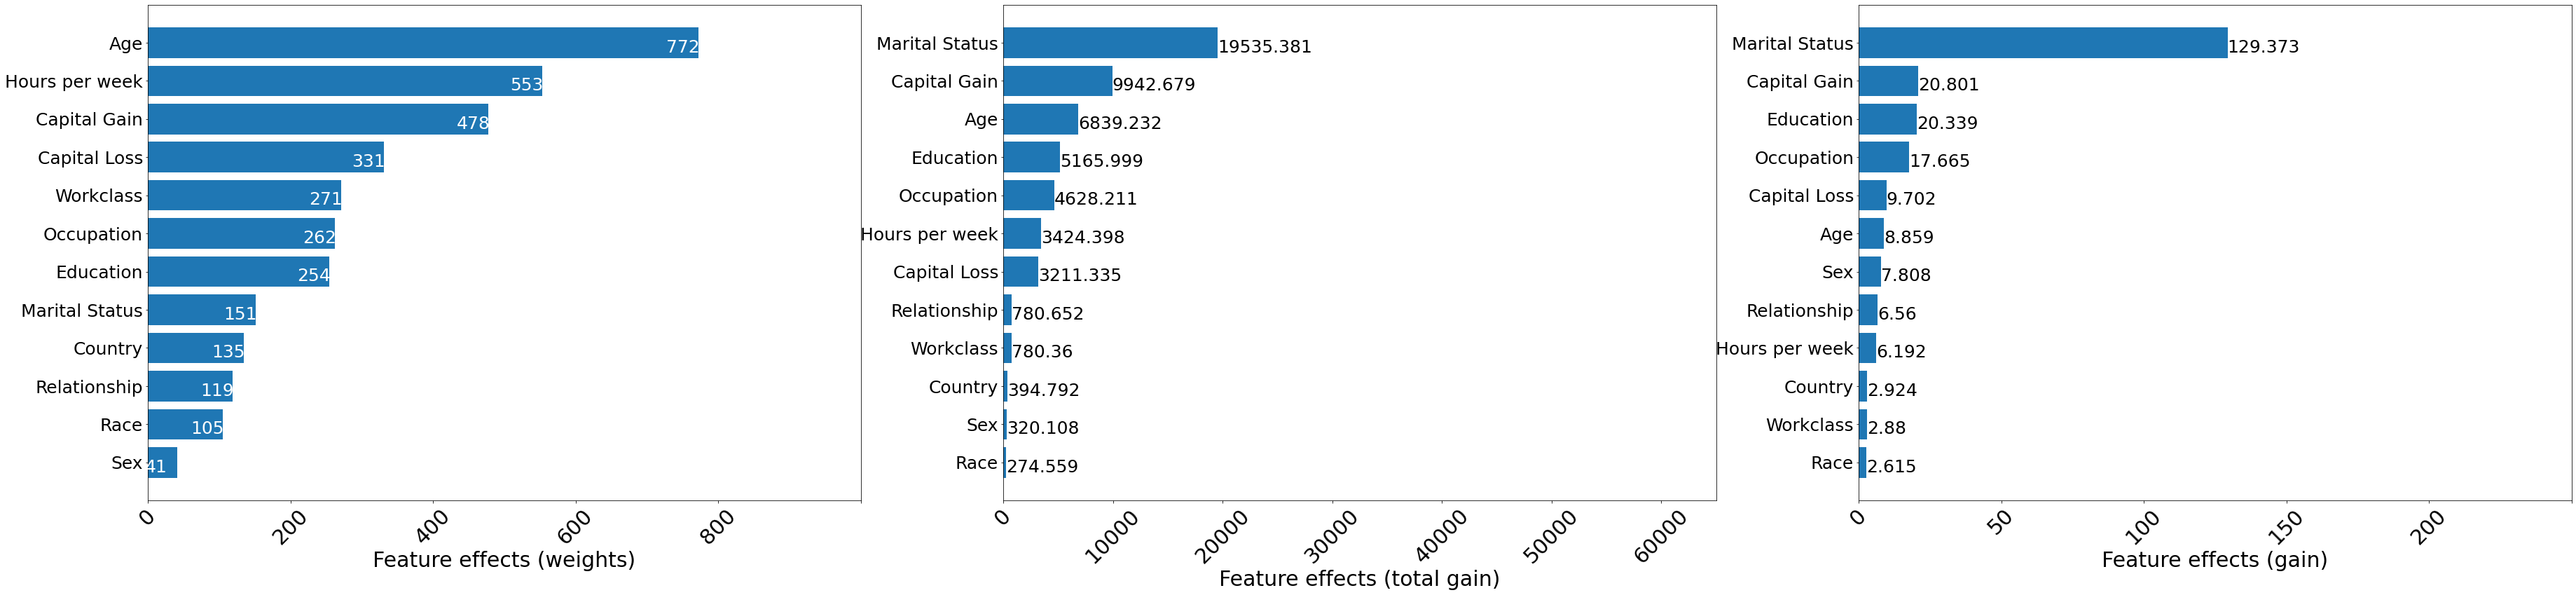

In [246]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(62, 13))
plot_importance(imp_by_weight_v, imp_by_weight_n, ax=ax1, xlabel='Feature effects (weights)', textxpos=45, right_x=1000, step=200 )
plot_importance(imp_by_gain_v, imp_by_gain_n, ax=ax2, xlabel='Feature effects (total gain)', textxpos=5, right_x=65000, step=10000, textcolor='black')
plot_importance(imp_by_a_gain_v, imp_by_a_gain_n, ax=ax3, xlabel='Feature effects (gain)', textxpos=0, right_x=250, step=50, textcolor='black')

Figure 2: Feature importances as measured by the total number of splits (left), total loss decrease due to feature (middle) and  average decrease in loss due to splitting on a particular feature (right)


When using the `weight` criterion for feature importance, all the continuous variables are ranked above categorical ones in terms of feature importance. This occurs because these continuous variables can be split multiple times at different levels in the tree, whereas binary variables  such as `Sex` can only be used to partition the data once, so the expected number of splits is smaller for such a variable. To avoid such biases, the feature importance  can be quantified by using the total and average gain in information (or, equivalently, decrease in objective). Although the `Marital Status` feature was used to parition the data only 151 times, it contributed the most to decreasing the loss, both across the entire ensamble and when averaged across the splits.

In general, the notion of importance should balance the information gain from making a split on a particular feature with how frequently this feature is used for splitting. Features such as `Age` may have a large cumulative gain courtesy to them being split on multiple times, but on average they may contribute significantly less to the outcome compared to other features such as `Capital Gain` who are split on significant number of times.

However, despite mitigating some of the shortcomings of the split-frequency feature importance, the gain notion of feature-importance suffers from *lack of consistency*, a property that allows one to compare feature effects across models. The interested reader is referred to [this](https://static-content.springer.com/esm/art%3A10.1038%2Fs42256-019-0138-9/MediaObjects/42256_2019_138_MOESM1_ESM.pdf) example (page 22) published by Lundberg et. al for details. Such a problem can be mitigated by defining the notion of feature importance with respect to Shapley values, which are consistent as well as faithful to the model (locally).

## Explaining xgboost with Tree SHAP: global knowledge from local explanations

As described in the [overview](../doc/source/methods/TreeSHAP.ipynb), the Tree SHAP algorithm implements two different perturbation methods (_path dependent_ and _interventional_ feature perturbation). Below, the fitted model is explained using both of these methods and the results are contrasted. 

### Path-dependent perturbation Tree SHAP


In [277]:
tree_exp_path = TreeExplainer(model, model_output='raw')

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Note that the `model_output` kwarg was set to `raw`, to indicate the fact that the model outputs log-odds ratios<sup>[(3)](#Footnotes) </sup>.
<a id='f_4'></a>


In [278]:
shap_values_path_dep = tree_exp_path.shap_values(X_test_proc)

The shap values computed in this way have the local accuracy property, as expected. That is, they sum to the difference between the model output to be explained and the reference value. 

In [380]:
np.max(np.abs(model.predict(dtest) - tree_exp_path.expected_value - shap_values_path_dep.sum(1)))

1.9073486e-05

The features which are most important for the predicting whether an individual makes an income greater than \$50,000 are shown in Figure 3, where the feature importance of feature $j$ is defined as:

$$
I_j = \frac{1}{N}\sum \limits_{i=1}^N |\phi_{i,j}|.
$$

Here $N$ is the size of the explained dataset. According to this criterion, the `Marital Status` feature seems to be the most important, followed by features such as `Age` or `Capital Gain`. This global view does not provide information about the _direction_ of the effect at individual level (i.e., whether the prediction that an individual earns more than \$50, 000 is affected positively or negatively by a particular faeture), the _magnitude_ of the effect at individual level (i.e., whether the `Marital Status` feature, the most important globally, has a significant impact on the prediction about each individual) or the _prevalence_ of a particular effect (how many members of the population are affected in similar ways by a particular feature).


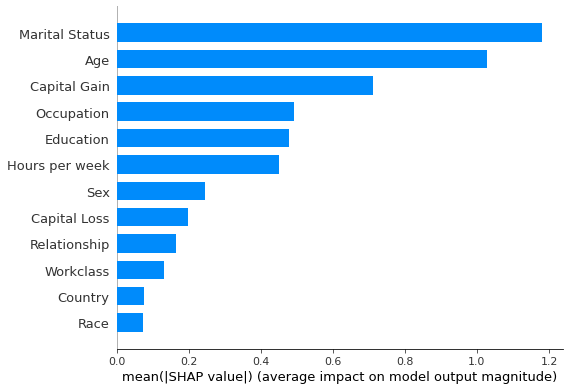

In [279]:
shap.summary_plot(shap_values_path_dep, X_test_proc, feat_names, plot_type='bar')

Figure 3: Most important features as predicted by the path-dependent perturbation Tree SHAP algorithm
<a id='figure_3'></a>

To answer such questions, the same feature ranking can be displayed in a _summary plot_ (Figure 4), which is an aggregation of local explanations.

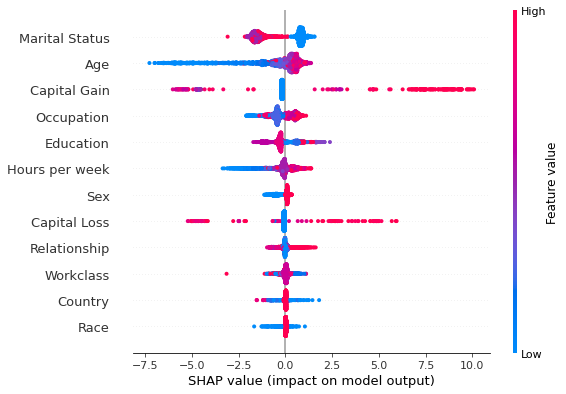

In [280]:
shap.summary_plot(shap_values_path_dep, X_test_proc, feat_names, class_names=target_names)

Figure 4: Summary plot of the path-dependent perturbation Tree SHAP explanations for the test set 
<a id='figure_4'></a>

In [283]:
from collections import Counter

feat_name = 'Marital Status'
decode_dict = {}
for i, val in enumerate(category_map[feature_names.index(feat_name)]):
    decode_dict[i] = val
print("Mapping of feature encoded values to readable values", decode_dict)

Mapping of feature encoded values to readable values {0: 'Married', 1: 'Never-Married', 2: 'Separated', 3: 'Widowed'}


The summary plot shows that being married increases the odds of making more than \$50, 000 and that, with two exceptions, being widowed decreases the odds of making an income above this threshold. Despite having a significant effect in aggregate, the `Age` feature does not affect all individuals as significantly: the impact on the prediction of this feature can be significantly negative for young individuals, making it unlikely that young individuals will be predicted to earn more than \$50,0000. However, while in general elderly tend to be more wealthy, the impact of this feature can be less significant compared to other "less important" features such as `Capital Loss`, `Capital Gain` or `Education`. 

The tails in the summary plot of the `Capital Loss` feature indicate that while this feature is less important than `Education` or `Sex` as far as the global model behaviour is concerned, for specific individuals this feature can be a stronger predictor of the income class than the aforementioned features. This granularity in explanations is beyond the reach of traditional methods for tree interpretability.  

The vertical spread in the summary plots is indicative of feature interactions, which can be identified approximately, as described in this example, through the `shap` dependence plot. [This](#interactions) section shows Tree Shap supports exact computation of *Shapley interaction values* which allow attributing a change in an outcome not only to the features, but also to first order interactions between features. 

In [250]:
def _dependence_plot(features, shap_values, dataset, dataset_feature_names, feature_names, category_map, display_features=None, **kwargs):
    """ 
    Plots dependence plots of specified features in a grid.
    
    NB: dataset_feature_names is a permutation of feature names because sklearn pipeline 
    changes column order.
    """
    
    def _set_fonts(fig, ax, fonts=None, set_cbar=False):
        """
        Sets fonts for axis labels and colobar.
        """

        ax.xaxis.label.set_size(xlabelfontsize)
        ax.yaxis.label.set_size(ylabelfontsize)
        ax.tick_params(axis='x', labelsize=xtickfontsize)
        ax.tick_params(axis='y', labelsize=ytickfontsize)
        if set_cbar:
            fig.axes[-1].tick_params(labelsize=cbartickfontsize)
            fig.axes[-1].tick_params(labelrotation=cbartickrotation)
            fig.axes[-1].yaxis.label.set_size(cbarlabelfontsize)

    # parse plotting args
    figsize = kwargs.get("figsize", (15, 10))
    nrows = kwargs.get('nrows', len(features))
    ncols = kwargs.get('ncols', 1)
    xlabelfontsize = kwargs.get('xlabelfontsize', 14)
    ylabelfontsize = kwargs.get('ylabelfontsize', 14)
    cbartickfontsize = kwargs.get('cbartickfontsize', 14)
    cbartickrotation = kwargs.get('cbartickrotation', 10)
    cbarlabelfontsize = kwargs.get('cbarlabelfontsize', 14)
    xtickfontsize = kwargs.get('xtickfontsize', 11)
    ytickfontsize = kwargs.get('ytickfontsize', 11)
    rotation_orig = kwargs.get('xticklabelrotation', 25)
    
    
    alpha = kwargs.get("alpha", 1)
    x_jitter_orig = kwargs.get("x_jitter", 0.8)
    grouped_features = list(zip_longest(*[iter(features)] * ncols))
    
    
    fig, axes = plt.subplots(nrows, ncols,  figsize=figsize)
    if nrows == len(features):
        axes = list(zip_longest(*[iter(axes)] * 1))


    for i, (row, group) in enumerate(zip(axes, grouped_features), start=1):
        for ax, feature in zip(row, group):
            if not feature:
                continue
            if isinstance(feature, list) or isinstance(feature, tuple):
                feature_index = feature_names.index(feature[0])
            else:
                feature_index = feature_names.index(feature)
            if feature_index in category_map:
                ax.set_xticks(np.arange(len(category_map[feature_index])))
                if i == nrows:
                    rotation = 90
                else:
                    rotation = rotation_orig
                ax.set_xticklabels(category_map[feature_index], rotation=rotation, fontsize=22)
                x_jitter = x_jitter_orig
            else:
                x_jitter = 0
            
            shap.dependence_plot(feature, 
                                 shap_values,
                                 dataset,
                                 feature_names=dataset_feature_names,
                                 display_features=display_features,
                                 interaction_index='auto',
                                 ax=ax,
                                 show=False,
                                 x_jitter=x_jitter,
                                 alpha=alpha
                                )
            if i!= nrows:
                ax.tick_params('x', labelrotation=rotation_orig)
            _set_fonts(fig, ax, set_cbar=True)
    
plot_dependence = partial(
    _dependence_plot, 
    dataset_feature_names=feat_names, 
    feature_names=feature_names,
    category_map=category_map,
)

The dependence plots (Figure 5) reveal that the strongest interaction of the `Marital Status` shap values are due to the `Hours per week` variable. Although the odds for earning in excess of \$50,000 are against people who are not married or have separated, they tend to be more favourable for individuals working long hours.

As far as `Age` is concerend, the odds of earning more increase as a person ages, and, in general, this variable is used by the model to assign individuals to a lower income class. People in their 30s-60s are thought to be more likely to make an income over \$50, 000 if their capital gains are high. Interestingly, for people over 60, high capital gains correlated negatively with making large incomes, a pattern that is perhaps not intuitive. 

As far as the `Hours per week` is concerned, one sees that older people working no to few hours a week are predicted better odds for making a larger income, and that, up to a certain threshold (of approximately 60 hours), working more hours increases the odds of a  $>\$50, 000$ prediction for all ages.

Finally, we note that not knowing the occupation hurts the odds of predicting a high income. No significant interactions between the sex of the individual (males in red), their occupation and their predicted odds are observed with the execption of, perhaps, `Admin` and `Blue Collar` groups. 

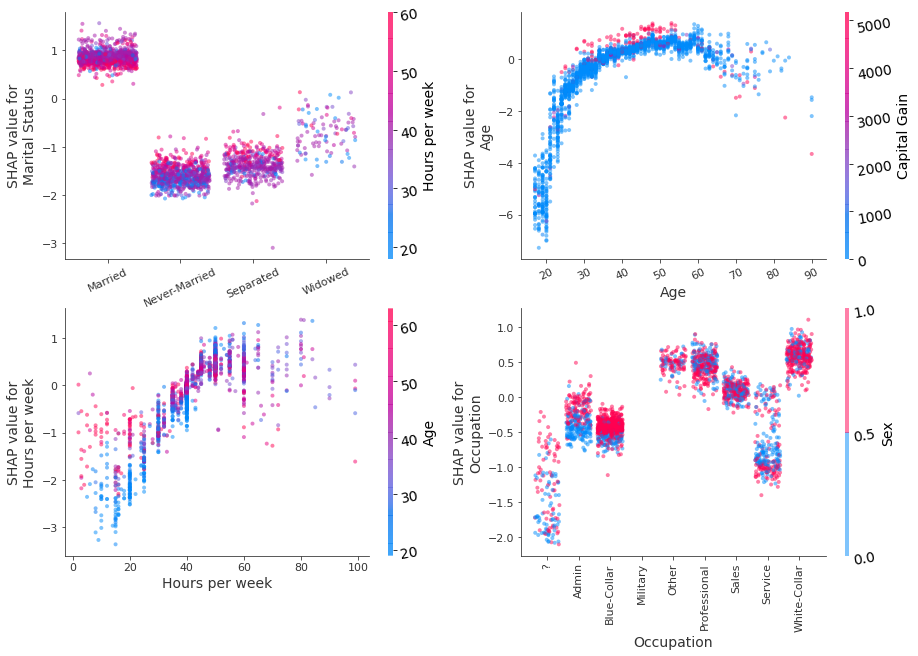

In [284]:
plot_dependence(
    ['Marital Status', 'Age', 'Hours per week', 'Occupation'], 
    shap_values_path_dep, 
    X_test_proc,  
    alpha=0.5, 
    x_jitter=0.8,
    nrows=2,
    ncols=2,
)

Figure 5: Decision plot of `Marital Status`, `Age`, `Hours per week`, `Occupation` features using the path-dependent perturbation Tree SHAP algorithm. Colouring is according to the value of the variable estimated to have the strongest interaction with the plotted variable. Jitter in the x direction has been applied to categorical variables to improve readability.
<a id='figure_5'></a>

Performing local explanations across multiple instances efficiently can provide insight into how features contributed to misclassifications and the most common causes of misclassification. This can be achieved by performing a similar analysis for those indiduals whose income was predicted below \$50,000 but who are known to make an income in excess of this threshold.

In [60]:
# identify false negatives
misclassified = (np.logical_and(y_test == 1, y_pred_test == 0)).nonzero()[0]
X_misclassified = X_test_proc[misclassified]
# explain the predictions
shap_vals_misclassified = shap_values_path_dep[misclassified, :]

The summary plot indicates that the feature with the most impact on misclassification is `Marital Status` and that the model does not correctly capture the fact that individuals who were never married, widowed or separated can also make high incomes.

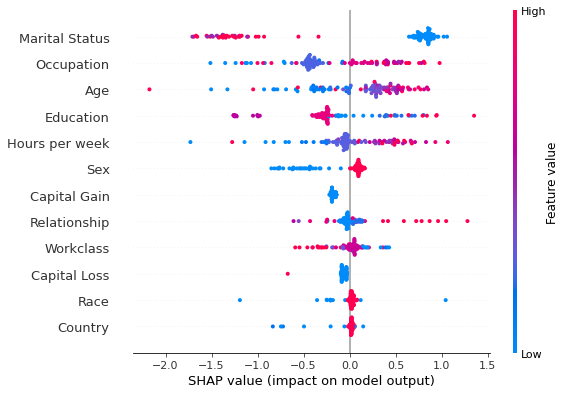

In [61]:
shap.summary_plot(shap_vals_misclassified, X_misclassified, feat_names )

Figure 6: Summary plot of path-dependent perturbation Tree SHAP explanations for individuals misclassified as earning less than \$50, 000. 
<a id='figure_6'></a>

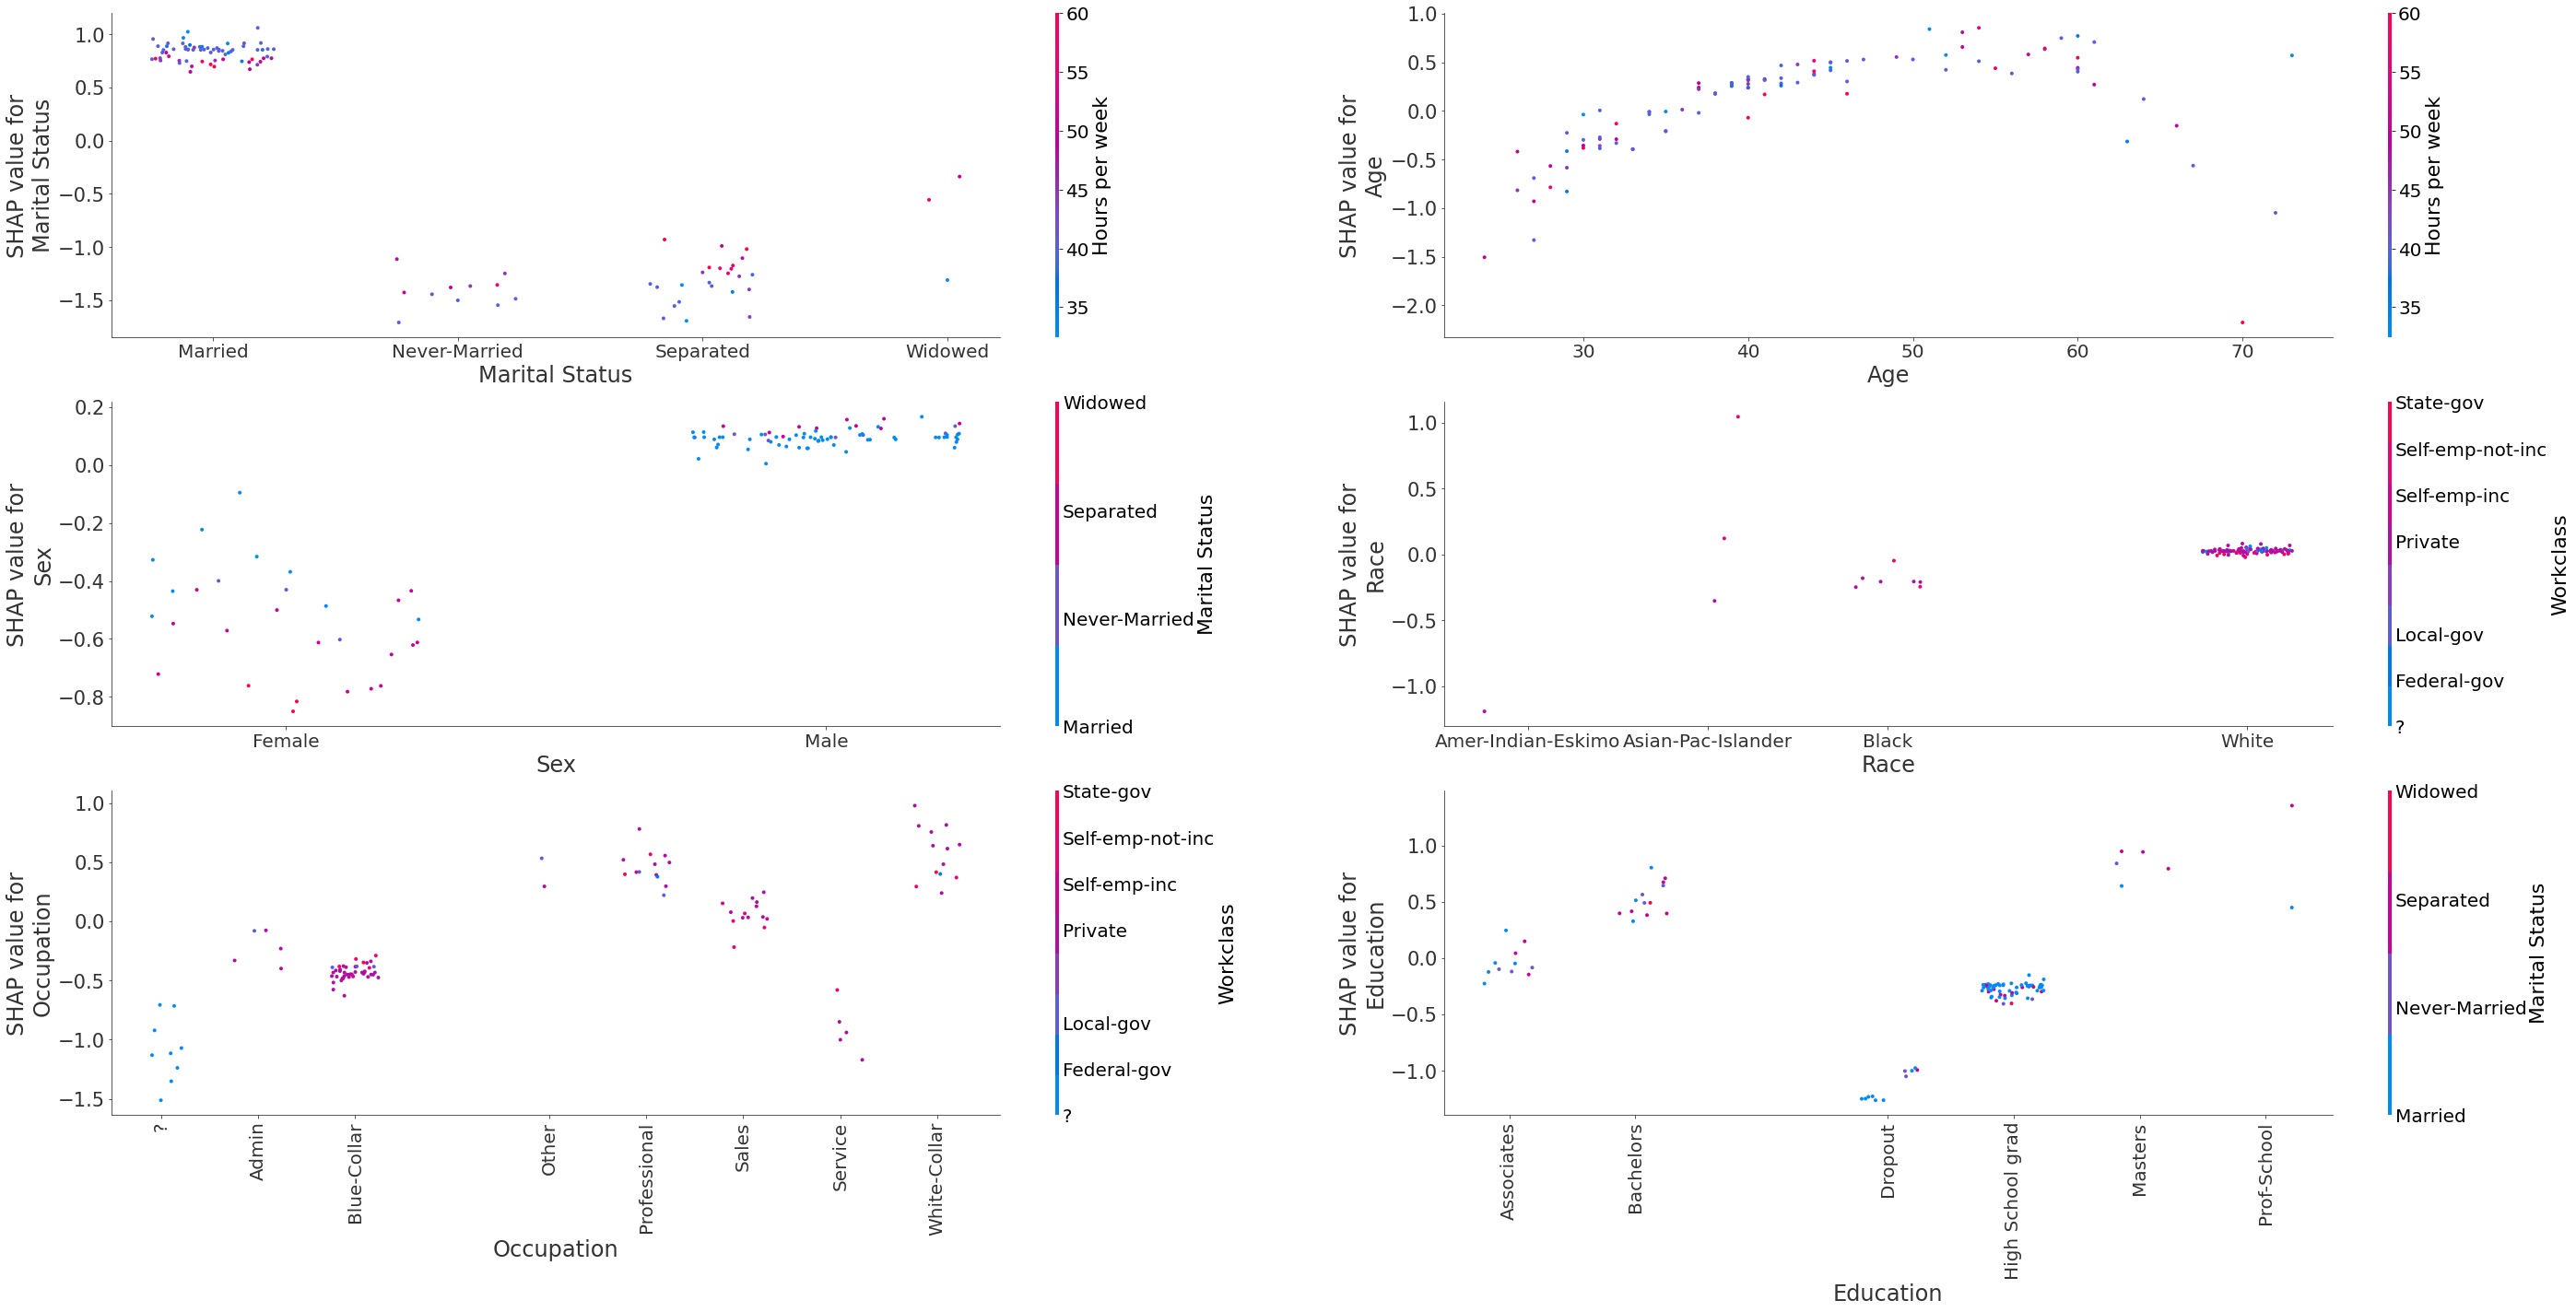

In [255]:
X_misclassified_display = decode_data(X_misclassified, feat_names)
plot_dependence(
    ['Marital Status', 'Age',  'Sex', 'Race', 'Occupation', 'Education'], 
    shap_vals_misclassified, 
    X_misclassified, 
    display_features=X_misclassified_display, 
    rotation=33,
    figsize=(47.5, 22), 
    alpha=1, 
    x_jitter=0.5,
    nrows=3,
    ncols=2,
    xlabelfontsize=24,
    xtickfontsize=20,
    xticklabelrotation=0,
    ylabelfontsize=24,
    ytickfontsize=21,
    cbarlabelfontsize=22,
    cbartickfontsize=20,
    cbartickrotation=0,
    
)

Figure 7: Decision plots of the variables `Marital Status`, `Age`,  `Sex`, `Race`, `Occupation`, `Education` using the path-dependent Tree SHAP algorithm for individuals misclassified as earning less than \$50, 000. 
<a id='figure_7'></a>


Analysing the plots above reveals that some of the patterns that can lead to misclassification are:
- individuals are not married or are divorced/widowed
- idividuals below 40 years old are expected to earn less, across all occupation categories 
- individuals are female; being single increases the likelihood of the model predicting odds against the high income class
- racial bias does not seem to be one of the drivers of misclassification, although we can see that for `Black` people odds contribution to odds is slightly negative whereas for white peoplethe contribution to odds is positive 
- individuals being `Blue-Collar` workers, working in the `Service` industry or individuals for which the occupation is unknown 
- individuals having dropped out of education or being high school graduates

### Interventional perturbation 

Recall that the goal of shap values computation for an instance $x$ is to attribute the difference $f(x) - \mathbb{E}_{\mathcal{D}}[f(x)]$ to $M$ input features. Here $\mathcal{D}$ represents the background data. Unlike the path-dependent perturbation algorithm which exploits the tree structure and cover information (derived from the training data) to obviate the need for a background dataset, the interventional perturbation algorithm follows a similar idea to [Kernel SHAP](../doc/source/methods/KernelSHAP.ipynb) and uses a background dataset to compute the expected value as the average of the leaves where the background samples fall plus the baseline model offset <sup>[(4)](#Footnotes) </sup> . As explained in the algorithm [overview](../doc/source/methods/TreeSHAP.ipynb#interventional), this allows explaining nonlinear transformations of the model output, so this method can be used to explain loss function fluctuations.

As discussed in [[2]](#References) and detailed in the [overview](../doc/source/methods/TreeSHAP.ipynb#interventional), this perturbation method enforces the conditional indepedence $x_{S} \perp x_{\bar{S}}$ where $\bar{S}$ is a subset of missing features. This section shows that this method is consistent with the path-dependent perturbation method, in the sense that it leads to very similar analysis conclusions assuming an appropriate background dataset is used.
<a id='source_3'></a>
<a id='f_3'></a>


Because the background dataset contains $30, 000$ examples, the next part of the example is **long running**. In practice sufficient accuracy can be achieved using a couple of hundred samples (the library authors recommend anywhere between 200 and 1000 examples). Instead you can **load the results** by calling the `load_shap_values` function.

In [130]:
tree_exp_interventional = TreeExplainer(model, X_train_proc)  

Passing 30000 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.


In [260]:
def load_shap_values():
    
    with open('data/shap_interv.pkl', 'rb') as f:
        shap_interv = pickle.load(f)
    
    return shap_interv 

In [274]:
shap_interv = load_shap_values()

In [ ]:
shap_interv = tree_exp_interventional.shap_values(X_test_proc)

 53%|===========         | 1365/2560 [22:00<19:15]       

Unfortunately, one notices that the local accuracy property does not hold for all examples. A number of issues are currently opened about this issue in the `shap` library github repository (see [here](https://github.com/slundberg/shap/issues/1151)).

In [413]:
errs = np.abs(model.predict(dtest) - tree_exp_interventional.expected_value - shap_interv.sum(1))

In [419]:
print(Counter(np.round(errs, 2)))

Counter({0.5: 2557, 0.84: 1, 0.58: 1, 0.36: 1})


The error observed seems to be the same for all but 3 examples, and for the majority of the examples could be due to the way the expected value is calculated, as explained in [this](#convergence) section.

One might be tempted to proceed to compare the feature rankings in Figures [3](#figure_3) and [9](#figure_9) in order to compare the two methods. Before doing so, one should bear in mind that:

1. Each point in Figure [8](#figure_8) is the average of the shap values computed for a given instance $x$ with respect to $R$ different background datasets. One can consider that for each instance to be explained the shap value of the $j$th feature is a random variable, denoted by $\Phi_{i,j}$. One way to define the importance of the $j$th feature, $I_j$, is 

$$
I_j = \frac{1}{N} \sum \limits_{i=1}^N |\mathbb{E}[\Phi_{i, j}]|,
$$

where the expectation is taken over the background distribution. This corresponds to the notion of feature importance according to which a feature is important for explaining the model behaviour over a given dataset if:
-  either the instances to explained are consistently affected by the feature, or the feature has a particularly large impact for certain subgroups and a small or moderate impact for the remainder. Traditional global explanation feature importances (Figure 9) hide this information whereas the summary plot in Figure 8 reveals why a particular feature was deemed important
- locally, one also requires that cancellation effects are not significant. In other words, for a particular instance, a feature would be considered as not important if, across different backgrounds, cancellation effects result in a small  average for the effect

It should be noted that the error $I_j$ is invers proportional to the square root of the size of the background dataset for a given dataset to be explained, so it is important to select a sufficient number of background samples in order to reduce the error of this estimate. 

2. The two methods explain the dataset with respect to different expected values, so the contributions will be different. This also arises because of the different set of conditional assumptions are made when estimating the indvidual contributions, as explained in the algorithm [overview](../doc/source/methods/TreeSHAP.ipynb).



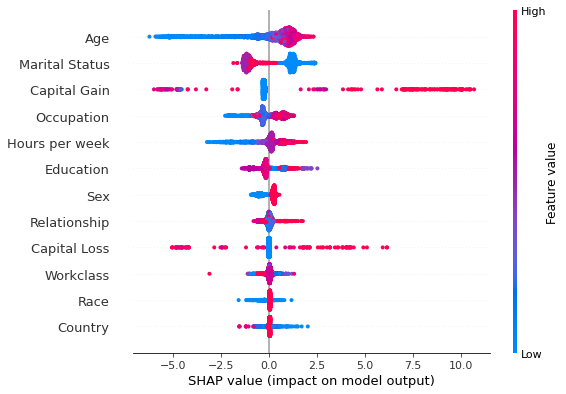

In [275]:
shap.summary_plot(shap_interv, X_test_proc, feat_names)

Figure 8: Summary plot of the interventional perturbation Tree SHAP explanations for the test set 
<a id='figure_8'></a>

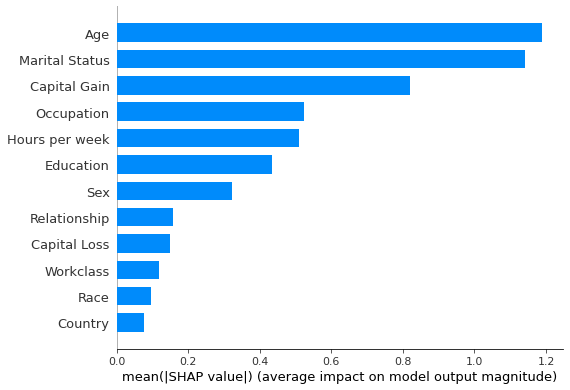

In [276]:
shap.summary_plot(shap_interv, X_test_proc, feat_names, plot_type='bar')

Figure 9: Most important features as predicted by the interventional perturbation Tree SHAP algorithm
<a id='figure_9'></a>

Instead of analysing the ranking, it is perhaps more instructive to look at the dependence plots and see if the conclusions from the previous model interpretation hold. Although the decision plots in Figure 10 show the same patterns as their counterparts in [Figure 5](#figure_5), different variables are found to have the strongest interaction with the variables of interest so the colouring of the plot is different. This is expected since the different conditional independence assumptions give rise to different magnitudes for the shap values, and therefore the estimations for the Pearson coefficients will be affected.  

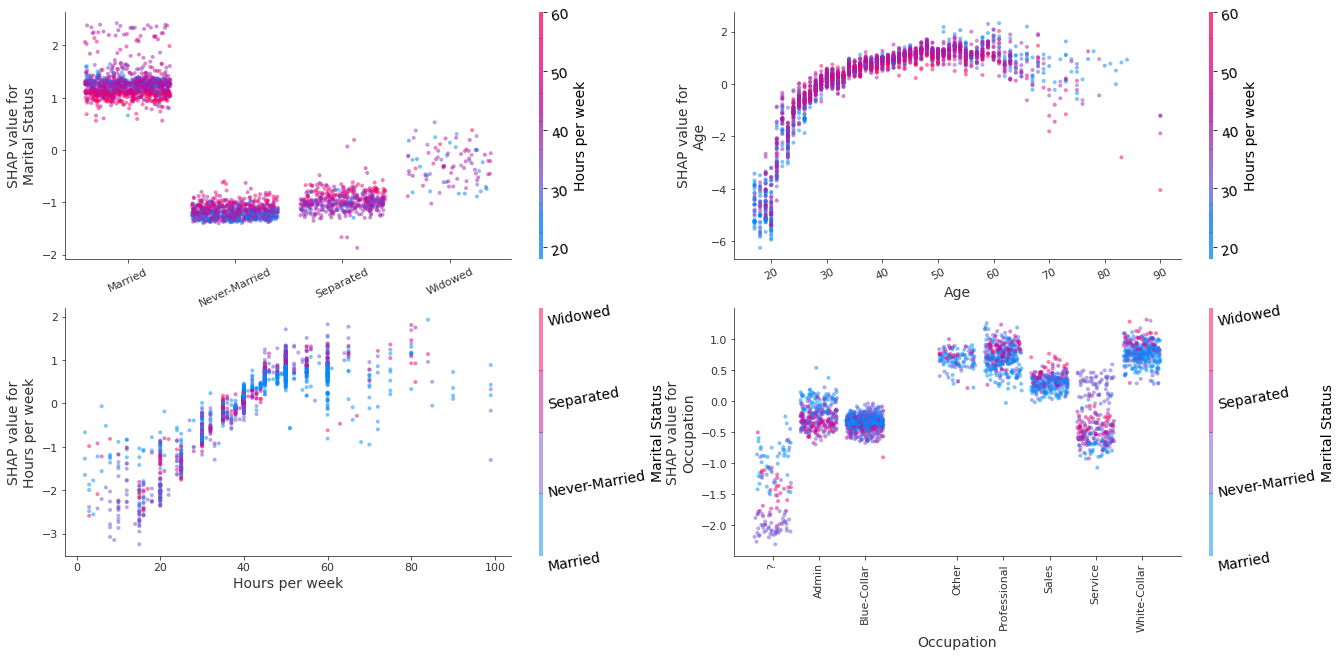

In [282]:
plot_dependence(['Marital Status', 'Age', 'Hours per week', 'Occupation'], 
                shap_interv, 
                X_test_proc, 
                display_features=X_display, 
                nrows=2,
                ncols=2,
                figsize=(22, 10),
                alpha=0.5)

Figure 10: Decision plots of the variables `Marital Status`, `Age`,  `Sex`, `Race`, `Occupation`, `Education` using the interventional perturbation Tree SHAP algorithm for the test set
<a id='figure_10'></a>

By changing, value of `feature` below, one can recolour the decision plots according to the interactions estimate from the path-dependent perturbation data. Generally, the same interaction patterns are observed, with the exception of `Age`, where the interaction with the `Capital Gain` feature is not conclusive.

In [285]:
path_dep_interactions = {
    'Marital Status': 'Hours per week',
    'Age': 'Capital Gain',
    'Hours per week': 'Age',
    'Occupation': 'Sex',
}

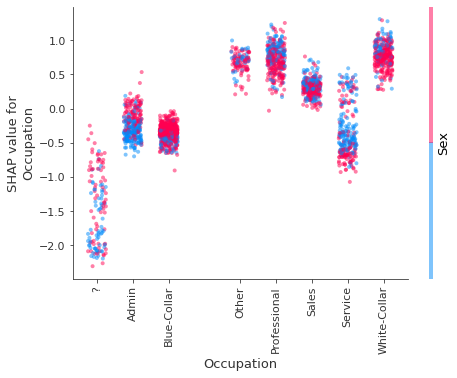

In [291]:
feature = 'Occupation'
x_jitter = 0.5 if feature in ['Occupation', 'Marital Status'] else 0
shap.dependence_plot(feature, 
                     shap_interv,
                     X_test_proc,
                     feature_names=feat_names,
                     display_features=X_display,
                     interaction_index=path_dep_interactions[feature],
                     alpha=0.5,
                     x_jitter=x_jitter
                    )

If interaction effects are of interest, these can be computed exactly using the path-dependent perturbation algorithm as opposed to approximated. The following section shows how this analysis can be performed.

### Model explanations with Shapley interaction values
<a id='interactions'></a>

As described in the algorithm [overview](../doc/source/methods/TreeSHAP.ipynb), path-dependent feature perturbation Tree Shap can attribute a change in outcome not only to the $M$ input features, but to the $M$ features and the first-order interactions between them. For each instance to be explained, a tensor of $M \times M$ numbers is returned. The diagonal of this tensor, indexed by $(i, i)$, represents the _main effects_ (i.e., due to the feature itself) whereas the off-diagonal terms indexed by $(i, j)$ represent the _interaction between the $i$th and the $j$th feature in the input_. Summing along the rows of an entry in the shapley interaction values tensor yields the $M$ shap values for that instance. Note that the interaction value is split equally between each feature so the returned matrix is symmetric;   the total interaction effect between feature $i$ and $j$ is therefore obtained by adding the two symmetric entries $(i,j)$ and $(j, i)$.

In [292]:
shap_interactions = tree_exp_path.shap_interaction_values(dtest)

Plots of the interactions between the features `Age`, `Sex`, `Education` and `Occupation` with `Capital Gain` are shown below.

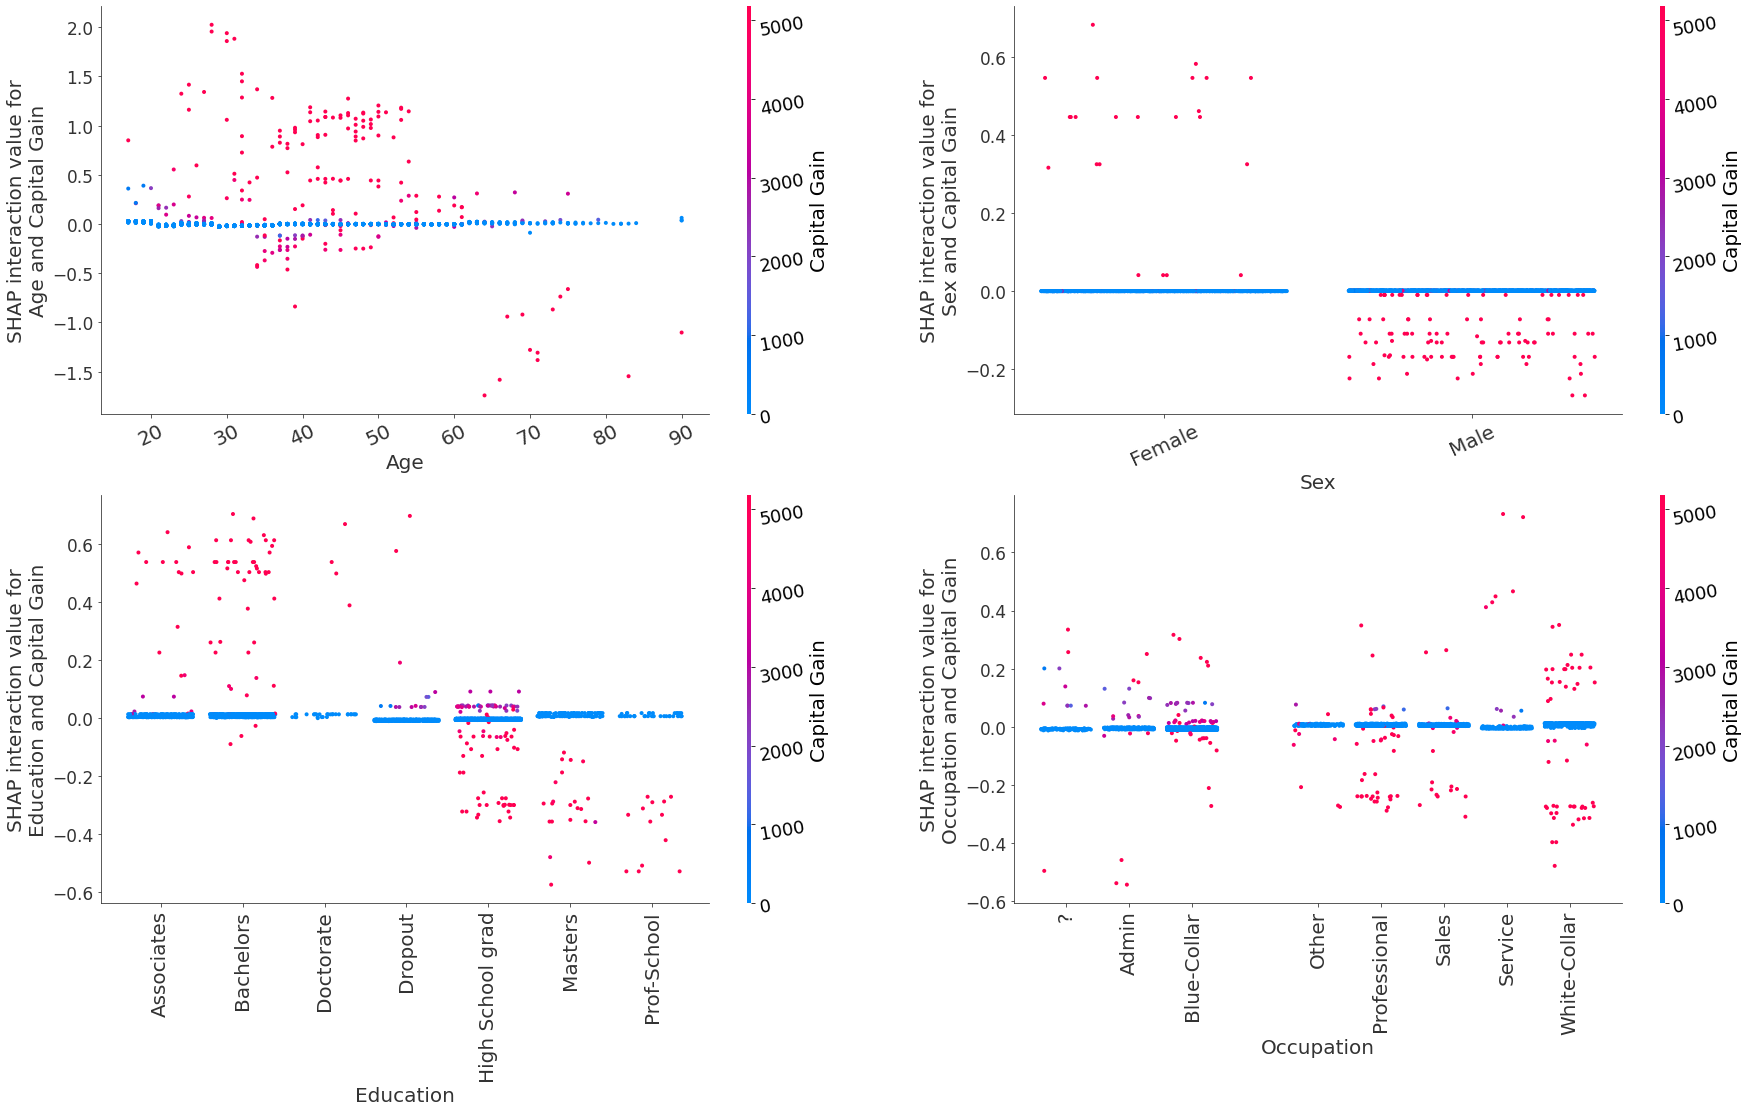

In [307]:
plot_dependence(
    [('Age', 'Capital Gain'),
    ('Sex', 'Capital Gain'), 
    ('Education', 'Capital Gain'), 
    ('Occupation', 'Capital Gain'), 
    ], 
    shap_interactions, 
    X_test_proc, 
    figsize=(30,16.5), 
    rotation=15, 
    ncols=2, 
    nrows=2,
    display_features=X_display,
    xtickfontsize=20,
    xlabelfontsize=20,
    ylabelfontsize=20,
    ytickfontsize=17,
    cbarlabelfontsize=20,
    cbartickfontsize=18,
)

Figure 11: Shap interaction values for the features `Age`, `Sex`, `Education` and `Occupation` with `Capital Gain`
<a id='figure_11'></a>


The model has captured the following patterns:
- The interaction between `Age` and `Capital` gain increases the odds of predicting an income >\$50,000 for most individuals below 60 years old but significantly decreases the ods for individuals above 60 years old. This interaction has no effect when the individuals don't have any capital gains
- For females, capital gains generally increase the prediction odds while for males they decrease them, although these interactions are rather weak 
- Having a capital gain and education level at `Masters` and `Prof-School` or `High School grad` decreases the prediction odds for higher income
- For individuals in occupation categories `Professional` and `Sales`, high capital gains slightly reduce the odds of predicting >\$50,000. For `White-Collar` individuals, high capital gain can both increase or decrease the odds.

The `plot_decomposition` function can be use to decompose the shap values of a particular feature into a set of shap values that do not account for the interaction with a specific feature and the interaction values with that specific feature, as shown below. This is depicted in Figure 12.

In [308]:
def plot_decomposition(feature_pair, shap_interaction_vals, features, feat_names, display_features=None, **kwargs):
    """
    Given a list containing two feature names (`feature_pair`), an n_instances x n_features x n_features tensor 
    of shap interaction values (`shap_interaction_vals`), an n_instances x n_features (`features`) tensor of 
    feature values and a list of feature names (which assigns a name to each column of `features`), this function 
    plots:
        - left: shap values for feature_pair[0] coloured by the value of feature_pair[1]
        - middle: shap values for feature_pair[0] after subtracting the interaction with feature_pair[1]
        - right: the interaction values between feature_pair[0] and feature_pair[1], which are subtracted 
        from the left plot to get the middle plot
        
    NB: `display_features` is the same shape as `features` but should contain the raw categories for categorical 
    variables so that the colorbar can be discretised and the category names displayed alongside the colorbar.
    """
    
    def _set_fonts(fig, ax, fonts=None, set_cbar=False):
        """
        Sets fonts for axis labels and colobar.
        """

        ax.xaxis.label.set_size(xlabelfontsize)
        ax.yaxis.label.set_size(ylabelfontsize)
        ax.tick_params(axis='x', labelsize=xtickfontsize)
        ax.tick_params(axis='y', labelsize=ytickfontsize)
        if set_cbar:
            fig.axes[-1].tick_params(labelsize=cbartickfontsize)
            fig.axes[-1].yaxis.label.set_size(cbarlabelfontsize)

    # parse plotting args
    xlabelfontsize = kwargs.get('xlabelfontsize', 21)
    ylabelfontsize = kwargs.get('ylabelfontsize', 21)
    cbartickfontsize = kwargs.get('cbartickfontsize', 16)
    cbarlabelfontsize = kwargs.get('cbarlabelfontsize', 21)
    xtickfontsize = kwargs.get('xtickfontsize', 20)
    ytickfontsize = kwargs.get('ytickfontsize', 20)
    alpha = kwargs.get('alpha', 0.7)
    figsize = kwargs.get('figsize', (44, 10))
    ncols = kwargs.get('ncols', 3)
    nrows = kwargs.get('nrows', 1)
    # compute shap values and shap values without interaction
    feat1_idx = feat_names.index(feature_pair[0])
    feat2_idx = feat_names.index(feature_pair[1])
    # shap values
    shap_vals = shap_interaction_vals.sum(axis=2)
    # shap values for feat1, all samples
    shap_val_ind1 = shap_interaction_vals[..., feat1_idx].sum(axis=1)
    # shap values for (feat1, feat2) interaction 
    shap_int_ind1_ind2 = shap_interaction_vals[:, feat2_idx, feat1_idx]
    # subtract effect of feat2
    shap_val_minus_ind2 = shap_val_ind1 - shap_int_ind1_ind2
    shap_val_minus_ind2 = shap_val_minus_ind2[:, None]

    # create plot

    fig, (ax1, ax2, ax3) = plt.subplots(nrows, ncols, figsize=figsize)

    # plot the shap values including the interaction
    shap.dependence_plot(feature_pair[0],
                         shap_vals,
                         features,
                         display_features = display_features,
                         feature_names=feat_names,
                         interaction_index=feature_pair[1],
                         alpha=alpha,
                         ax=ax1,
                         show=False)
    _set_fonts(fig, ax1, set_cbar=True)

    # plot the shap values excluding the interaction
    shap.dependence_plot(0,
                         shap_val_minus_ind2,
                         features[:, feat1_idx][:, None],
                         feature_names=[feature_pair[0]],
                         interaction_index=None,
                         alpha=alpha,
                         ax=ax2,
                         show=False,
                         )
    ax2.set_ylabel(f' Shap value for  {feature_pair[0]} \n wo {feature_pair[1]} interaction')
    _set_fonts(fig, ax2)
    
    # plot the interaction value
    shap.dependence_plot(feature_pair,
                         shap_interaction_vals,
                         features,
                         feature_names=feat_names,
                         display_features=display_features,
                         interaction_index='auto',
                         alpha=alpha,
                         ax=ax3,
                         show=False,
                        )
    _set_fonts(fig, ax3, set_cbar=True)
    

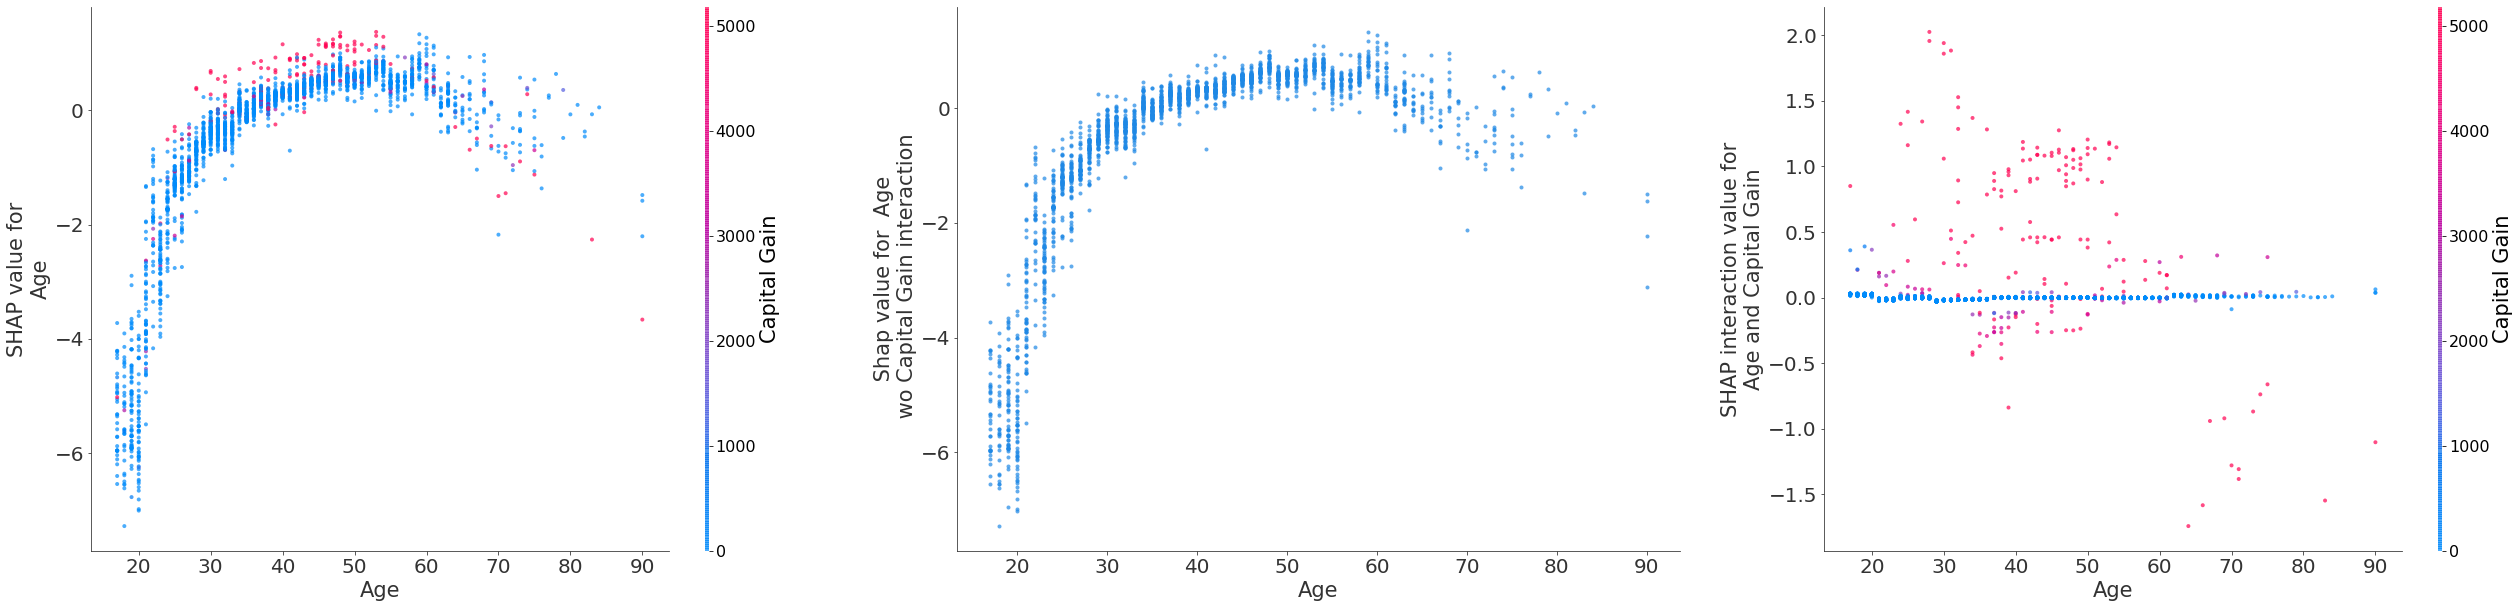

In [309]:
feature_pair = ('Age', 'Capital Gain')
plot_decomposition(
    feature_pair, 
    shap_interactions, 
    X_test_proc, 
    feat_names, 
    display_features=X_display,
)

Figure 12: A decomposition of the shap values for `Age` (left) into shap values for `Age` excluding the `Capital Gain` interaction (middle). The total interaction between `Age` and `Capital Gain` shown on right.

### Whitebox vs blackkbox model explanations: a comparison with Kernel SHAP 
<a id='convergence'></a>


The main drawbacks of model-agnostic methods such as [Kernel SHAP](../doc/source/methods/KernelSHAP.ipynb) is their sample complexity along with the variability in the results obtained. Given enough samples, the feature attributions estimated Kernel SHAP algorithm approach their exact values and give rise to the same feature importance rankings, as shown below.

Below, both the Tree SHAP and Kernel SHAP algorithms are used to explain `100` instances from the test set using a background 
dataset of `200` samples. For the Kernel SHAP algorithm, each explanation is computed `10` times to account for the variability in the estimation.

In [310]:
n_background_samples = 200
n_explained = 100
background_dataset, y_background = resample(X_train_proc, y_train, n_samples=n_background_samples, replace=False, random_state=0)

In [311]:
X_display_background = decode_data(background_dataset, feat_names)
X_explain = X_test_proc[:n_explained, :]

In [316]:
tree_explainer = TreeExplainer(model, background_dataset)
tree_shap_values = tree_explainer.shap_values(X_explain)

`xgboost` requires the model inputs to be a `DMatrix` instance, so `predict_fcn` needs to account for this transformation to avoid errors.

In [136]:
predict_fcn = lambda x: model.predict(xgb.DMatrix(x, feature_names=feat_names))
kernel_explainer = KernelShap(predict_fcn)

In [138]:
kernel_explainer.fit(background_dataset)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


KernelShap(meta={
    'name': 'KernelShap',
    'type': ['blackbox'],
    'explanations': ['local', 'global'],
    'params': {
        'groups': None,
        'group_names': None,
        'weights': None,
        'summarise_background': False
    }
})

To assess convergence, Kernel SHAP is run with the numbers of samples specified in `n_samples` for `n_runs`.

In [145]:
n_runs = 10
n_samples = [50, 100, 500, 1000, 5000, 10000]

In [ ]:
results = defaultdict(list)
times = defaultdict(list)

for n_samp in n_samples:
    print(f"Number of samples {n_samp}")
    for run in range(n_runs):
        t_start = timer()
        exp = kernel_explainer.explain(X_explain, nsamples=n_samp)
        t_end = timer()
        times[str(n_samp)].append(t_end - t_start)
        results[str(n_samp)].append(exp.shap_values[0])
        
results['time'] = times
        
with open('data/kernel_convergence.pkl', 'wb') as f:
    pickle.dump(results, f)

In [317]:
with open('data/kernel_convergence.pkl', 'rb') as f:
    convergence_data = pickle.load(f)

To compare the two algorithms, the mean absolute deviation from the ground truth provided by the Tree SHAP algorithm with interventional feature perturbation is computed. For each number of samples, either the maximum mean absolute deviation across the feature, or the mean of this quantity across the features is computed. This calculation can be performed for one instance, or averaged across an entire distribution. The plots below show that all these quantities aproach to the ground truth values. A threshold of $1\%$ from the effect of the most important feature (`Marital Status`) is depicted.

In [318]:
def get_errors(convergence_data, instance_idx=None):
    """
    Compute the mean and max maximum absolute deviation of Kernel SHAP values
    from Tree SHAP values for a specific instance or as an average over instances.
    """
    
    mad = []
    for key in convergence_data:
        if key != 'time':
            mad.append(np.abs(tree_shap_values - np.mean(convergence_data[key], axis=0)))
    
    if instance_idx is not None:
        err_max = [max(x[instance_idx, :]) for x in mad]
        err_mean =[np.mean(x[instance_idx, :]).item() for x in mad]
    else:
        err_max = [max(x.mean(axis=0)) for x in mad]
        err_mean =[np.mean(x.mean(axis=0)).item() for x in mad]
    
    return err_max, err_mean 


def plot_convergence(err_mean, err_max, n_samples, threshold, instance_idx=None):
    """
    TODO: 
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.loglog(n_samples, err_max, '--*')
    ax1.plot([0] + n_samples, [threshold]*(len(n_samples)+1), '--', color='gray', linewidth='3')
    ax1.grid(True)
    ax1.set_ylabel('Estimation error (max over all features)')
    ax1.set_xlabel('Number of samples')
    
    ax2.loglog(n_samples, err_mean, '--*')
    ax2.plot([0] + n_samples, [threshold]*(len(n_samples)+1), '--', color='gray', linewidth='3')
    ax2.grid(True)
    ax2.set_ylabel('Estimation error (mean over all features)')
    ax2.set_xlabel('Number of samples')
    if instance_idx is not None:
        plt.suptitle(f'Convergence of the Kernel SHAP algorithm to exact shap values (instance {instance_idx})')
    else:
        plt.suptitle('Convergence of the Kernel SHAP algorithm to exact shap values (mean)')

In [319]:
threshold = 0.01*np.max(np.mean(np.abs(tree_shap_values), axis=0))

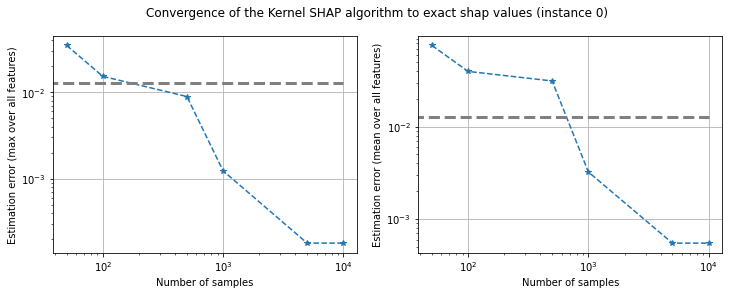

In [320]:
err_max, err_mean = get_errors(convergence_data, instance_idx=0)
plot_convergence(err_max, err_mean, n_samples, threshold, instance_idx=0)

Figure 13: Converge of Kernel SHAP to true values according to the maximum error (left) and mean error (right) for instance 0

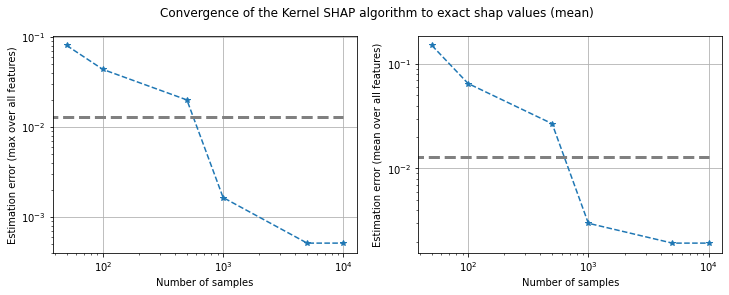

In [321]:
e_err_max, e_err_mean = get_errors(convergence_data)
plot_convergence(e_err_max, e_err_mean, n_samples, threshold)

Figure 14: Converge of Kernel SHAP to true values according to the maximum error (left) and mean error (right) averaged across 100 instances

If a high enough number of samples is selected, the algorithms yield the same global patterns, as shown below.

In [153]:
n_explained = 500
X_explained = X_test_proc[:n_explained, :]
kernel_shap_values = kernel_explainer.explain(X_explained, nsamples=1000)

In [154]:
tree_shap_values = tree_explainer.shap_values(X_explained)

Again, the local accuracy check reveals a large (compare value below vs shap values scale) difference between the expected sum of shap values and the actual sum.

In [431]:
errs = np.round(np.abs(model.predict(xgb.DMatrix(X_explained, feature_names=feat_names)) - tree_explainer.expected_value - tree_shap_values.sum(1)), 2)
print(Counter(errs))

Counter({0.5: 498, 0.84: 1, 0.58: 1})


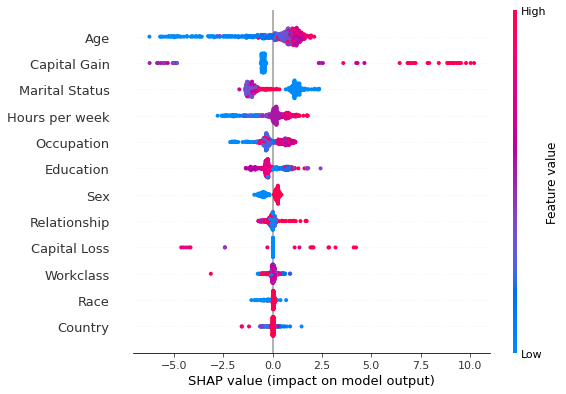

In [382]:
shap.summary_plot(tree_shap_values, X_explained, feat_names)

While the Tree SHAP values take a few seconds to compute, the Kernel SHAP takes a few minutes to provide estimates for the shap values. Note that this is also a consequence of the fact that the implementation of Tree SHAP is distributed.

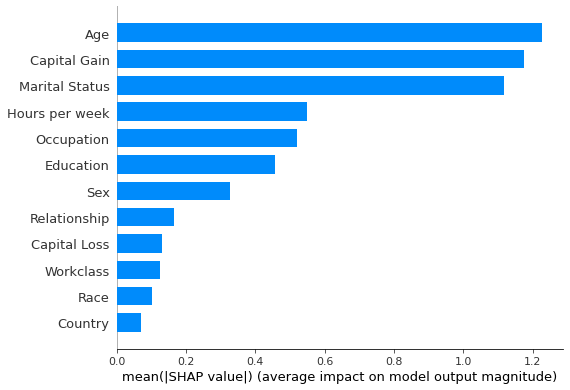

In [155]:
shap.summary_plot(tree_shap_values, X_explained, feat_names, plot_type='bar')

Figure 15: Feature importances estimated using the interventional feature perturbation Tree SHAP algorithm

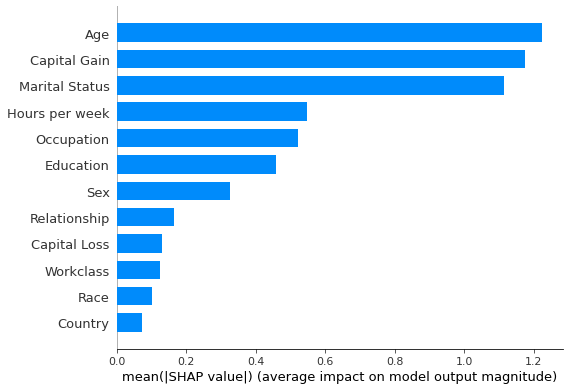

In [156]:
shap.summary_plot(kernel_shap_values.shap_values[0], X_explained, feat_names, plot_type='bar')

Figure 16: Feature importances estimated using the Kernel SHAP algorithm

In [215]:
print(f"Max absolute deviation from ground truth: {np.round(np.max(np.abs(tree_shap_values - kernel_shap_values.shap_values[0])), 4)}.")
print(f"Min absolute deviation from ground truth: {np.round(np.min(np.abs(tree_shap_values - kernel_shap_values.shap_values[0])), 4)}.")

Max absolute deviation from ground truth: 0.1244.
Min absolute deviation from ground truth: 0.0.


Since the errors incurred in estimating the shap values are relatively small, the feature importances shown in Figures 15 and 16 are identical.

In [170]:
average_prediction = model.predict(xgb.DMatrix(background_dataset, feature_names=feat_names)).mean()
kernel_exp_value = kernel_explainer.expected_value
tree_exp_value = tree_explainer.expected_value
print(f"Average prediction on background data is the expected value of kernel explainer: {np.abs(average_prediction - kernel_exp_value) < 1e-3}")
print(f"Average expected value for kernel explainer is the same as the tree explainer: {np.abs(kernel_exp_value - tree_exp_value) < 1e-3}")

Average prediction on background data is the expected value of kernel explainer: True
Average expected value for kernel explainer is the same as the tree explainer: False


The expected values of the two explainers appear to be different between the two explainers despite their use of the background dataset.

In [211]:
print(f"The difference between the expected values is {np.round(np.abs(kernel_exp_value - tree_exp_value),2)}.")

The difference between the expected values is 0.5.


In [212]:
print(f"Model base score: {json.loads(model.save_config())['learner']['learner_model_param']['base_score']}")

Model base score: 0.500000


This differences arises because Tree Shap takes into account `base_score` the initial model bias, used by `xgboost`to make predictions at the start of training. This parameter value does not matter so long the training process succeeds so it can be set to 0 to eliminate the differences.

## Model explanations using xgboost `predict` method

The `xgboost` library implements an optimised version of the path-dependendent feature perturbation algorithm, which is also internally used by the `shap` library. `xgboost` also provides an optimised algorithm for computing the shap interaction values.

The `predict` method can output the shap values if called as follows: 

In [224]:
dexplain = xgb.DMatrix(X_explain, feature_names=feat_names)
xgb_shap_vals = model.predict(dexplain, pred_contribs=True)

In [225]:
print(f"shap values shape: {xgb_shap_vals.shape}")

shap values shape: (100, 13)


Note that there are only 12 features in the datasets. The last column is the expected value with respect to which the feature contributions are computed. 

One can also estimate the shap interaction values as follows:

In [226]:
xgb_shap_interaction_vals = model.predict(dexplain, pred_interactions=True)

In [227]:
print(f"shap values shape: {xgb_shap_interaction_vals.shape}")

shap values shape: (100, 13, 13)


Note that the expected value is again returned in the last column.

The `xgboost` library also implements an approximate feature attribution method, first described by Sabaas [here](https://github.com/andosa/treeinterpreter). This feature attribution method is similar in spirit to Shapley value, but does not account for the effect of variable order as explained [here](https://static-content.springer.com/esm/art%3A10.1038%2Fs42256-019-0138-9/MediaObjects/42256_2019_138_MOESM1_ESM.pdf) (pp. 10-11). This explanation method can be invoked as follows:

In [234]:
xgb_sabaas = model.predict(dexplain, pred_contribs=True, approx_contribs=True)

## Footnotes

<a id='Footnotes'></a>

[(1)](#f_1): One can derive the stated formula by noting that the probability of the positive class is $p_i = 1/( 1 + \exp^{-\hat{y}_i})$ and taking its logarithm.

[(2)](#f_2): See the algorithm [overview](../doc/source/methods/TreeSHAP.ipynb#path_dependent) for a brief explanation of coverage. 

[(3)](#f_4): `model_output=raw` should always be used with the path-dependent perturbation for classification problems in `xgboost`, irrespective of whether the model is trained with the `binary:logitraw` or `binary:logitstic`. Even though a model trained with the latter outputs probabilities, internally `xgboost` explains the output in margin space due to the `model_output=raw` option. To explain the proability output of a model, one should use the interventional algorithm and pass `model_output=probability` to the constructor along with the objective `binary:logistic` to the training function.  

[(4)](#f_3): The base offset represents the leaf value before training. It can be specified as part of `params` as `'base_score'` and defaults to `0.5`.

## References 

<a id='References'></a>



[[1]](#source_4) Hastie, T., Tibshirani, R. and Friedman, J., 2009. The elements of statistical learning: data mining, inference, and prediction, p. 310, Springer Science & Business Media.

[[2]](#source_3) Lundberg, S.M., Erion, G., Chen, H., DeGrave, A., Prutkin, J.M., Nair, B., Katz, R., Himmelfarb, J., Bansal, N. and Lee, S.I., 2020. From local explanations to global understanding with explainable AI for trees. Nature machine intelligence, 2(1), pp.56-67.